# Разработка модели ранжирования

Цель нашей работы разработать релевантную модель, спобную предоставлять пять похожих товаров из базы данных в ответ на запрос по одному товару.

В нашем распоряжении:

**base.csv** - анонимизированный набор товаров.

Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

**train.csv** - обучающий датасет.

Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

**validation.csv** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv.


**validation_answer.csv** - правильные ответы к предыдущему файлу.

## Выгрузка данных и знакомство с данными

Отразим используемые модули в рамках одной ячейки для удобства.

In [1]:
!pip install faiss-gpu

In [2]:
!pip install catboost

In [3]:
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Загрузим файл в переменные.

In [5]:
try:
    df_base = pd.read_csv('/content/gdrive/My Drive/base.csv', index_col=0)

except:
    df_base = pd.read_csv('C://Users//roma_//OneDrive//Рабочий стол//DATA//Проект Мастерская 2//base.csv', index_col=0)

df_train = pd.read_csv('https://raw.githubusercontent.com/romakulikov/workshop2/main/train.csv', index_col=0)
df_validation = pd.read_csv('https://raw.githubusercontent.com/romakulikov/workshop2/main/validation.csv', index_col=0)
validation_answer = pd.read_csv('https://raw.githubusercontent.com/romakulikov/workshop2/main/validation_answer.csv', index_col=0)

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Привет!

У меня не получилось загрузить на github настолько большой файл как base.csv.
    
Ссылка на файл в Гугл Диск: https://drive.google.com/file/d/1dXzq5XuldQWM08HRsKoBObLaobjpLUGb/view?usp=sharing
    
    
</div>

In [6]:
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [7]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [8]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [10]:
df_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [11]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [12]:
validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [13]:
validation_answer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Данные успешно подгружены, информация о признаках преобразована в векторы, проведем предобработку.

## Преодработка и анализ распределения данных

### Проверка на явные дубликаты

In [14]:
print(
    'Количество явных дубликтов в base.csv:', df_base.duplicated().sum(), '\n',
    '\nКоличество явных дубликтов в df_train:', df_train.duplicated().sum(), '\n',
    '\nКоличество явных дубликтов в df_validation:', df_validation.duplicated().sum(), '\n',
    '\nКоличество явных дубликтов в validation_answer:', validation_answer.duplicated().sum(), '\n',
     )

Количество явных дубликтов в base.csv: 0 
 
Количество явных дубликтов в df_train: 0 
 
Количество явных дубликтов в df_validation: 0 
 
Количество явных дубликтов в validation_answer: 8498 



Как мы видим, в данных отсутствую дубликаты за исключением validation_answer. При этом мы можем заключить то, что товары в validation могут быть похожи на один и тот же товар base, в чем нет противоречий и аномалий, потому оставляем обнаруженные дубликаты.

### Проверка на неявные дубликаты в df_train

Проверим на возможные неявные дубликаты в тренировочной выборке

In [15]:
columns = df_train.select_dtypes(include='number').columns.tolist()

df_train.duplicated(subset=columns).sum()

0

Неявные дубликаты отсутсвуют в **df_train**.

### Распределение в данных

Построим гистограммы распределения и изучим данные в наших датасетах.

<Figure size 1500x1000 with 0 Axes>

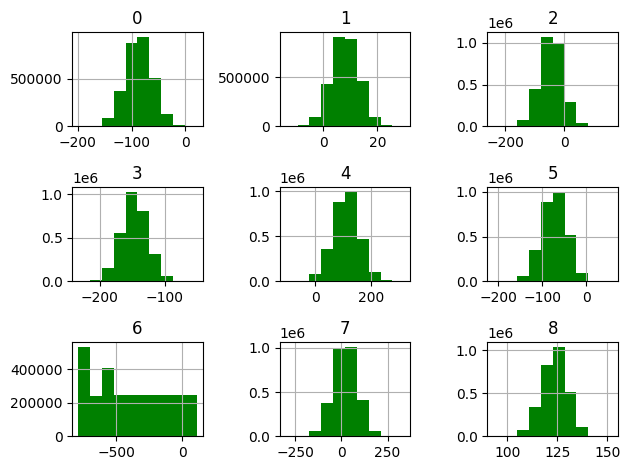

<Figure size 1500x1000 with 0 Axes>

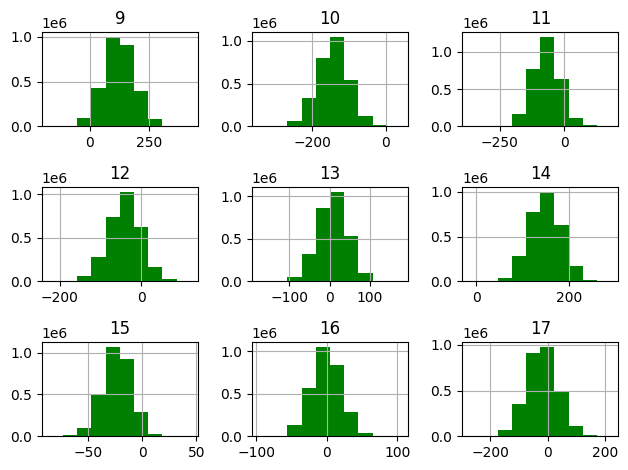

<Figure size 1500x1000 with 0 Axes>

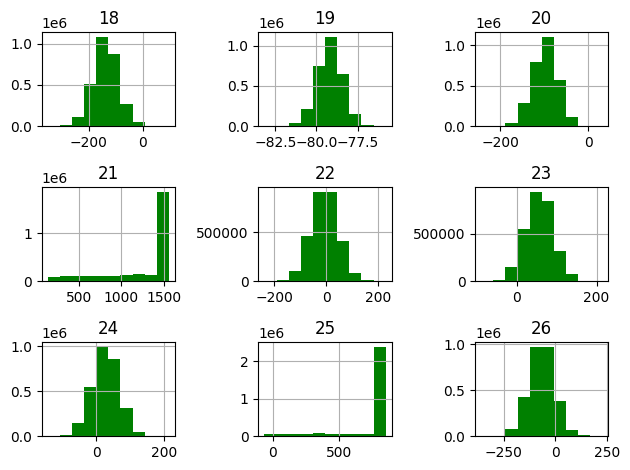

<Figure size 1500x1000 with 0 Axes>

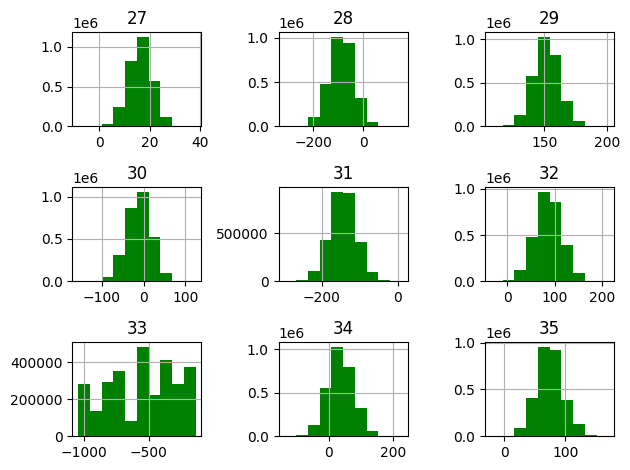

<Figure size 1500x1000 with 0 Axes>

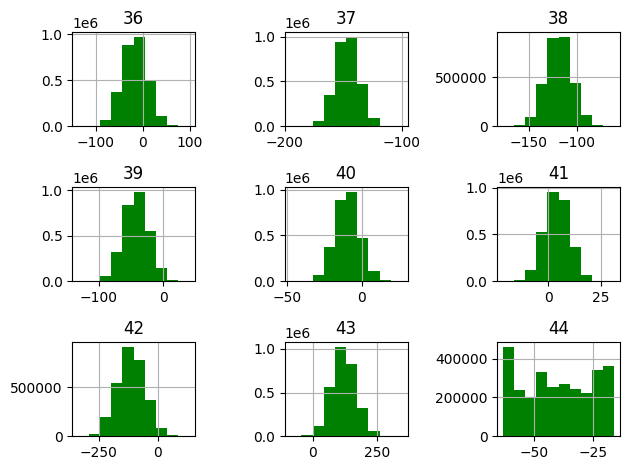

<Figure size 1500x1000 with 0 Axes>

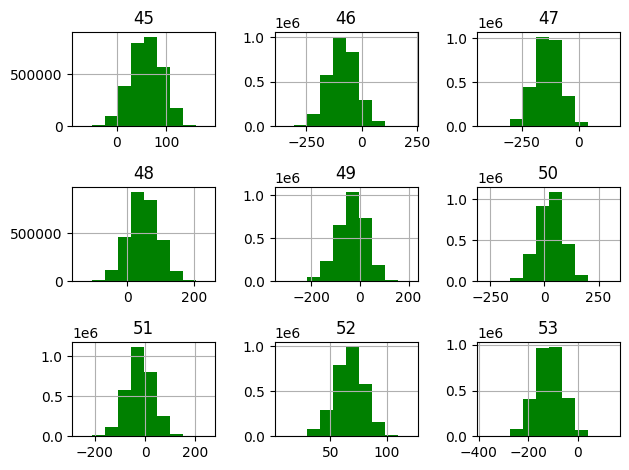

<Figure size 1500x1000 with 0 Axes>

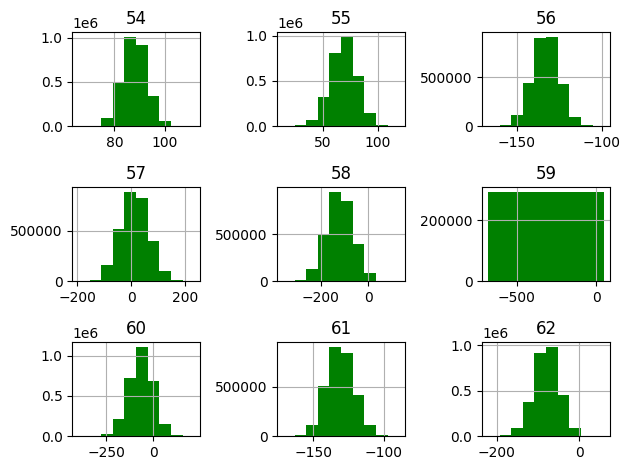

<Figure size 1500x1000 with 0 Axes>

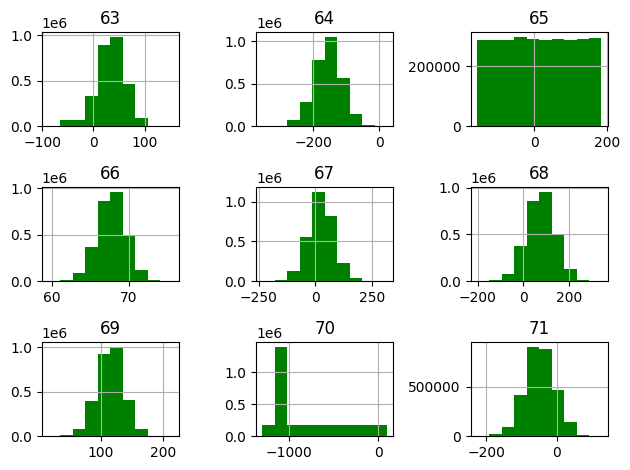

In [16]:
start = 0
stop = 9

columns = df_base.columns
while stop <= len(columns):
   plt.figure(figsize=(15, 10))
   ls = columns[start:stop]
   df_base[ls].hist(color='g')
   plt.tight_layout()
   plt.show()

   start = stop
   stop += 9

if start < len(columns):
  plt.figure(figsize=(15, 10))
  ls = columns[start:]
  df_base[ls].hist(color='g')
  plt.tight_layout()
  plt.show()

<Figure size 1500x1000 with 0 Axes>

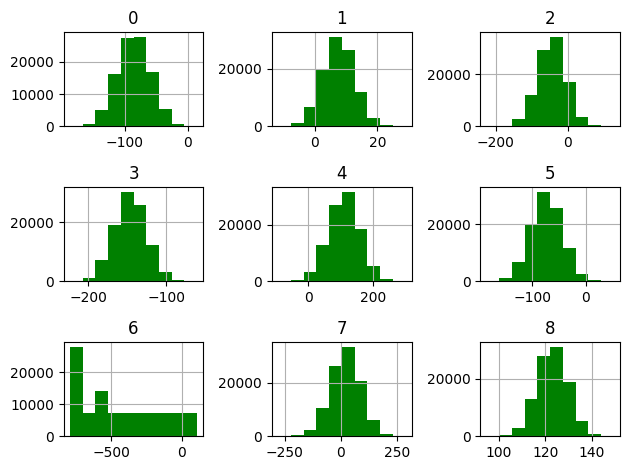

<Figure size 1500x1000 with 0 Axes>

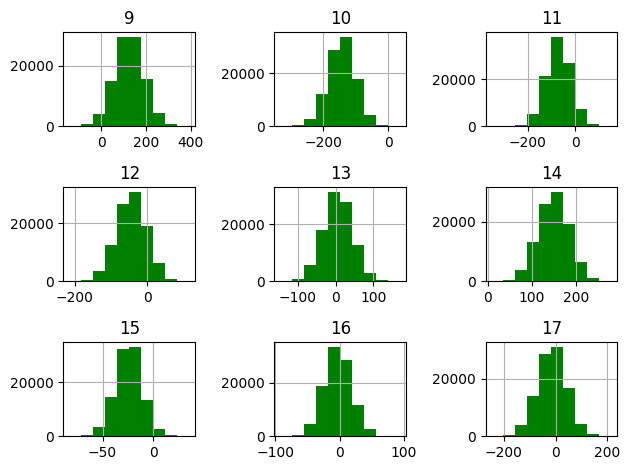

<Figure size 1500x1000 with 0 Axes>

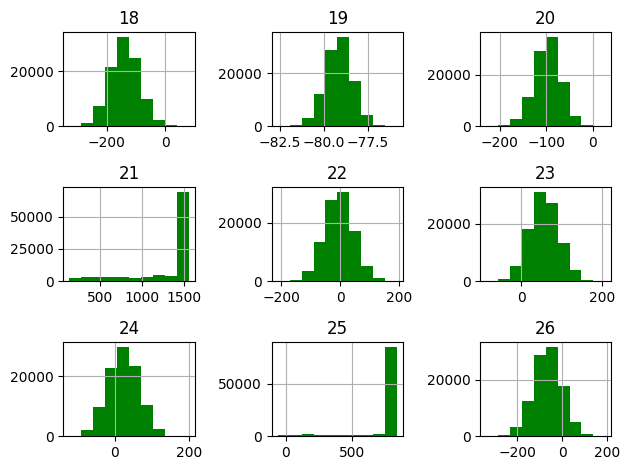

<Figure size 1500x1000 with 0 Axes>

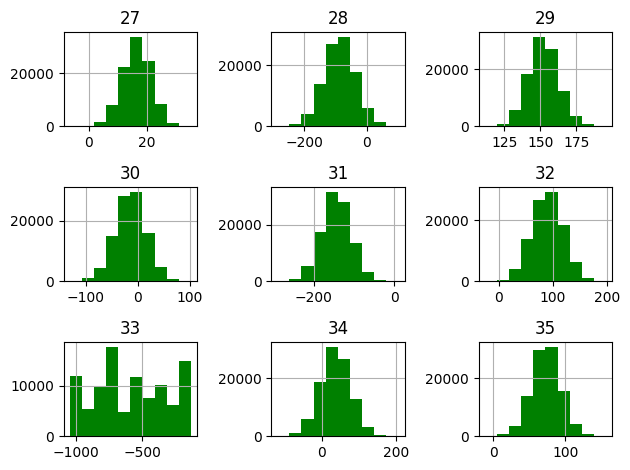

<Figure size 1500x1000 with 0 Axes>

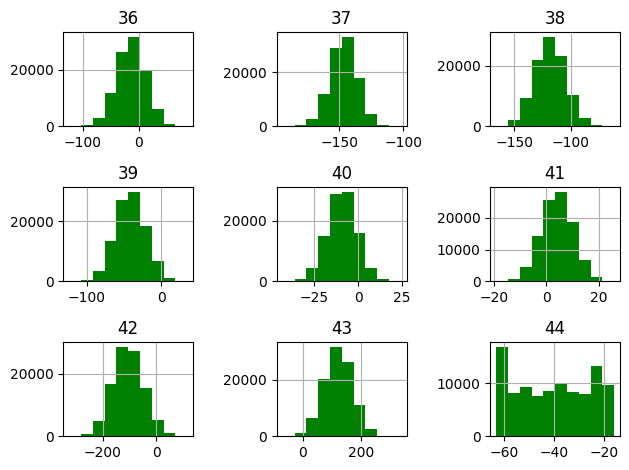

<Figure size 1500x1000 with 0 Axes>

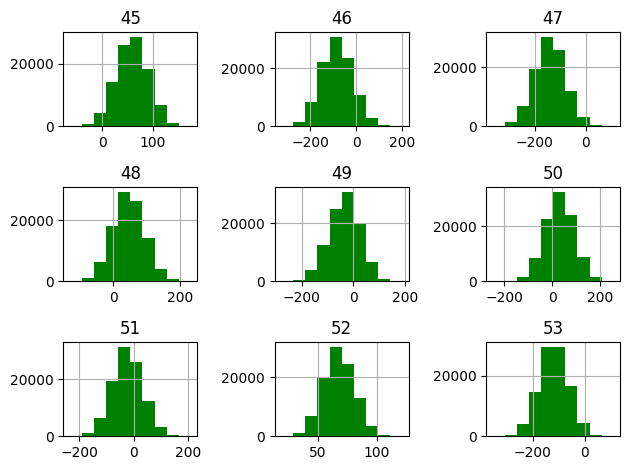

<Figure size 1500x1000 with 0 Axes>

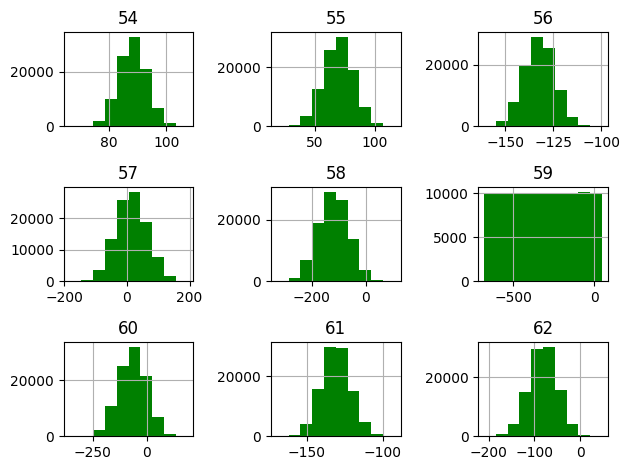

<Figure size 1500x1000 with 0 Axes>

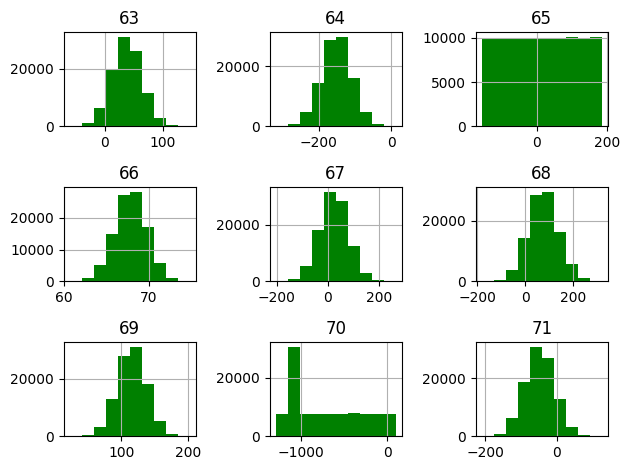

In [17]:
start = 0
stop = 9

columns = df_train.select_dtypes(include='number').columns.tolist()
while stop <= len(columns):
   plt.figure(figsize=(15, 10))
   ls = columns[start:stop]
   df_train[ls].hist(color='g')
   plt.tight_layout()
   plt.show()

   start = stop
   stop += 9

if start < len(columns):
  plt.figure(figsize=(15, 10))
  ls = columns[start:]
  df_train[ls].hist(color='g')
  plt.tight_layout()
  plt.show()

<Figure size 1500x1000 with 0 Axes>

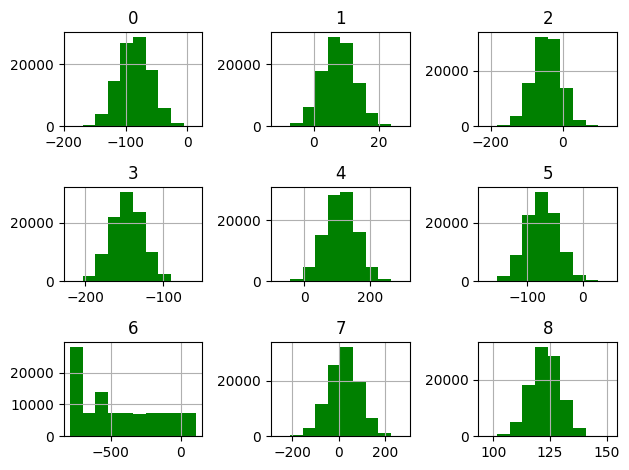

<Figure size 1500x1000 with 0 Axes>

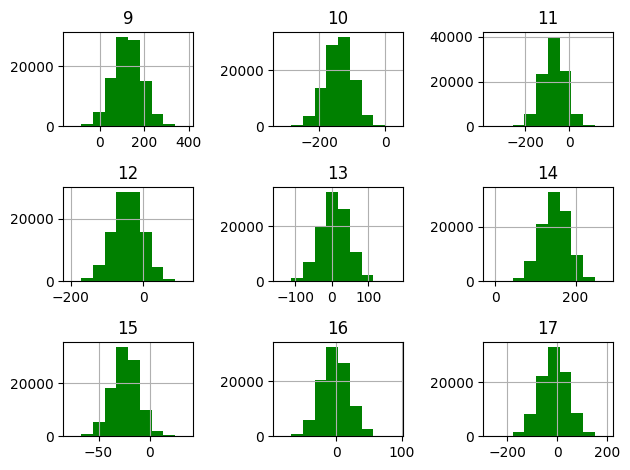

<Figure size 1500x1000 with 0 Axes>

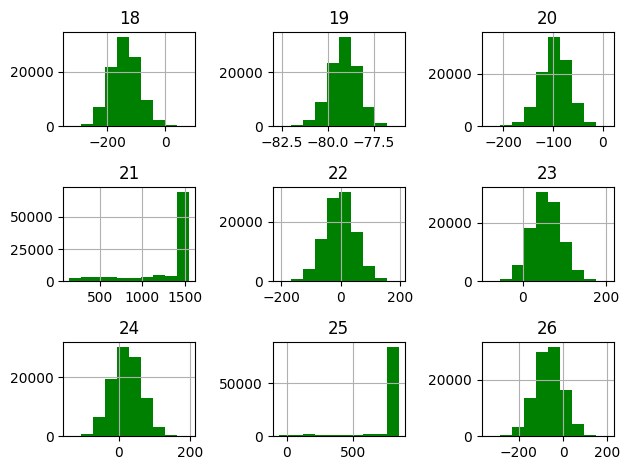

<Figure size 1500x1000 with 0 Axes>

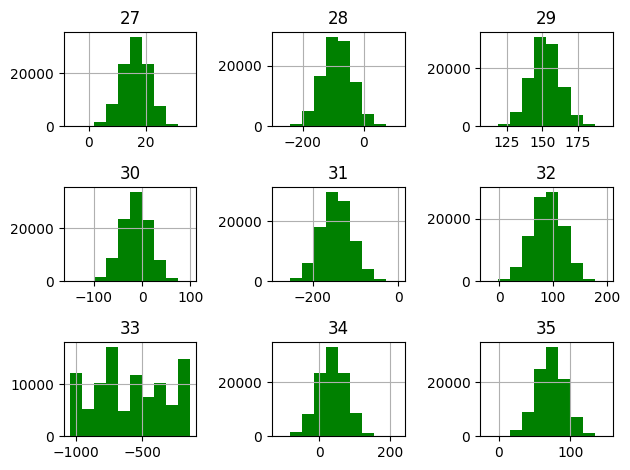

<Figure size 1500x1000 with 0 Axes>

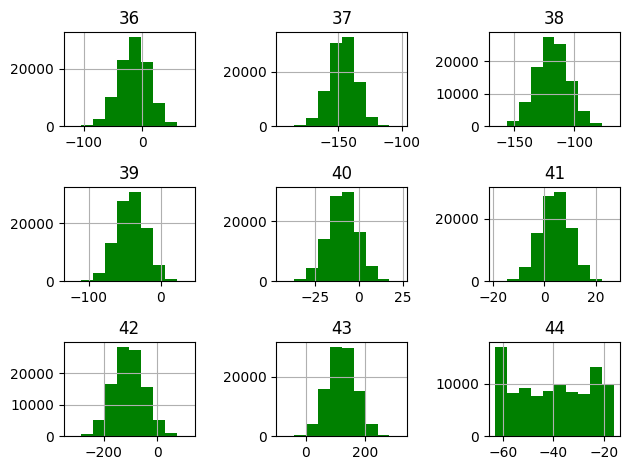

<Figure size 1500x1000 with 0 Axes>

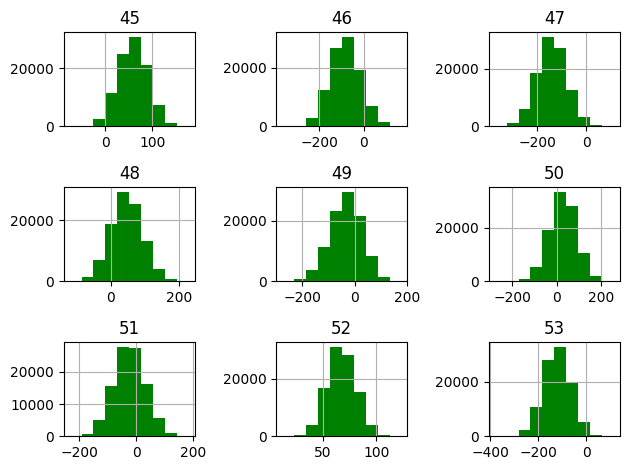

<Figure size 1500x1000 with 0 Axes>

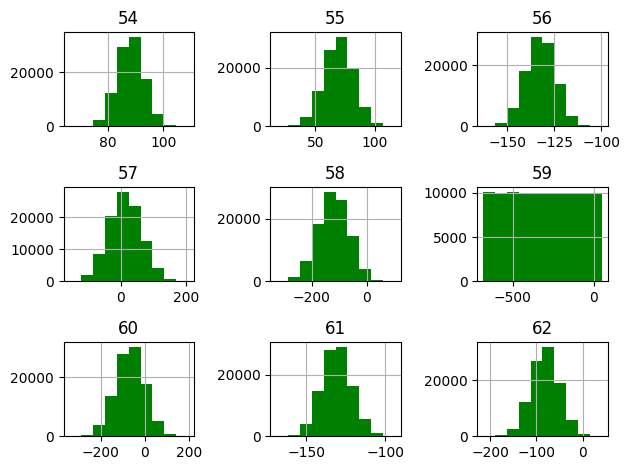

<Figure size 1500x1000 with 0 Axes>

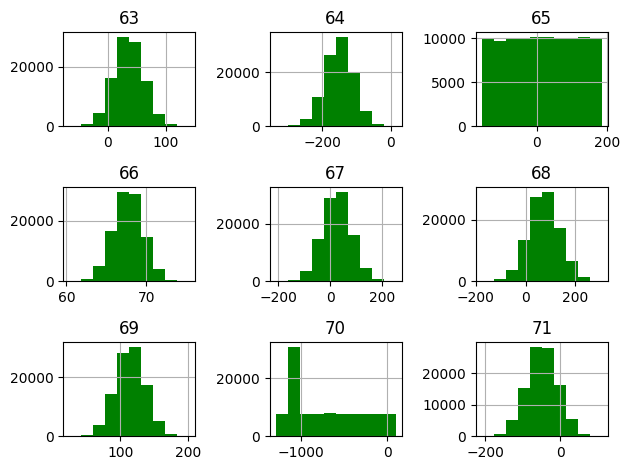

In [18]:
start = 0
stop = 9

columns = df_validation.columns
while stop <= len(columns):
   plt.figure(figsize=(15, 10))
   ls = columns[start:stop]
   df_validation[ls].hist(color='g')
   plt.tight_layout()
   plt.show()

   start = stop
   stop += 9

if start < len(columns):
  plt.figure(figsize=(15, 10))
  ls = columns[start:]
  df_validation[ls].hist(color='g')
  plt.tight_layout()
  plt.show()

Исходя из распределения, мы видим что часть столбцов имеют ненормальное распределение, что мешает качественной работе index faiss.

### Инжиниринг данных

Для работы модели данные столбцов "21", "25", "70" будут полезны в бинарном представлении при сравнении вектора кандидата и вектора, который был найден в базе данных, потому будет верным решением на стадии определения кандидатов faiss столбцы удалить, а на стадии обучения и прогнозирования модели использовать информацию из указанных столбцов.

Удалим столбцы, сохранив данные в отдельных переменных, и сохраним наиболее часто встречающееся значения в столбцах "21", "25", "70" за отдельными переменными, подтвердим их единое значение в наших выборках.

In [19]:
del_col = ['6', '21', '25', '33', '44', '59', '65', '70']

In [20]:
base = df_base.drop(del_col, axis=1)
train = df_train.drop(del_col, axis=1)
validation = df_validation.drop(del_col, axis=1)

Создадим переменные, которые понадобятся нам на этапе создания признаком для тренировки модели.

In [21]:
df_base['21'].value_counts().head(3)

1507.231274    1727961
1248.126198      40784
1342.641120      32933
Name: 21, dtype: int64

In [22]:
print(df_train['21'].mode().values[0] == df_base['21'].mode().values[0])
print()
df_train['21'].value_counts().head(3)

True



1507.231274    64100
1248.126198     1701
1342.641120     1224
Name: 21, dtype: int64

In [23]:
print(df_validation['21'].mode().values[0] == df_base['21'].mode().values[0])
print()
df_validation['21'].value_counts().head(3)

True



1507.231274    64389
1248.126198     1675
1342.641120     1270
Name: 21, dtype: int64

In [24]:
comval_21 = df_base['21'].mode().values[0]

In [25]:
df_base['25'].value_counts().head(3)

813.770071    2323620
366.779583      43208
175.595709       6585
Name: 25, dtype: int64

In [26]:
print(df_train['25'].mode().values[0] == df_base['25'].mode().values[0])
print()
df_train['25'].value_counts().head(3)

True



813.770071    83337
175.595709      659
701.226241      201
Name: 25, dtype: int64

In [27]:
print(df_validation['25'].mode().values[0] == df_base['25'].mode().values[0])
print()
df_validation['25'].value_counts().head(3)

True



813.770071    83002
175.595709      675
701.226241      180
Name: 25, dtype: int64

In [28]:
comval_25 = df_base['25'].mode().values[0]

In [29]:
df_base['70'].value_counts().head(3)

-1074.464888    1223397
-782.676180        6867
-597.491204         845
Name: 70, dtype: int64

In [30]:
print(df_train['70'].mode().values[0] == df_base['70'].mode().values[0])
print()
df_train['70'].value_counts().head(3)

True



-1074.464888    22875
-597.491204        47
-1185.335157        7
Name: 70, dtype: int64

In [31]:
print(df_validation['70'].mode().values[0] == df_base['70'].mode().values[0])
print()
df_validation['70'].value_counts().head(3)

True



-1074.464888    23006
-597.491204        44
-799.363667         8
Name: 70, dtype: int64

In [32]:
comval_70 = df_base['70'].mode().values[0]

Далее выделим целевую переменную для **train**.

In [33]:
target_train = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)
train.drop("Target", axis=1, inplace=True)

ООпределим за переменной **num_columns** столбцы с количественными переменными для их стандартизации, которую и проведем в следующей ячейке, используя класс **StandardScaler()**. Данные трансформируем обучив класс на **base**.


In [34]:
num_columns = train.select_dtypes(include='number').columns.tolist()

In [35]:
scaler = StandardScaler()
scaler.fit(base)

train[num_columns] = scaler.transform(train[num_columns])
validation[num_columns] = scaler.transform(validation[num_columns])
base[num_columns] = scaler.transform(base[num_columns])

Для работы нам понадобиться "справочник индексов" нашей базы данных, закрепим его в переменной **base_index**.

In [36]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

Данные подготовлены для поиска кандидатов посредством **faiss**.

## Поиск кандидатов средствами faiss для тренировочной выборке

Создадим объект **"index"** от faiss. Определив его размерность и количество в центроид в 1700, что является квадратным корнем от количества объектов в нашей базе данных. Исходя из ранее проведенных экспериментах определим количество кандидатов на каждой запрос в 100.

In [37]:
dim = base.shape[1]
topn = 100

In [38]:
index = faiss.index_factory(dim, "IVF1700,Flat")

Обучим наш "index" и добавим в него данные.

In [39]:
index.train(np.ascontiguousarray(base.values).astype('float32'))

index.add(np.ascontiguousarray(base.values).astype('float32'))

Определим количество посещаемых кластеров с помощью параметра nprobe. Исходя из проделанных экспериментов, остановимся на 100 кластерах.

In [40]:
index.nprobe = 100

Далее запустим поиск кандидатов от **faiss**.

In [41]:
dist_faiss, idx = index.search(np.ascontiguousarray(train.values).astype('float32'), topn)

Оценим полученные результаты.

In [42]:
acc = 0

for target, el in zip(target_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

acc5 = 0

idx_5 = [sublist[:5] for sublist in idx.tolist()]

for target, el in zip(target_train.values.tolist(), idx_5):
    acc5 += int(target in [base_index[r] for r in el])

acc2 = 0

idx_2 = [sublist[:2] for sublist in idx.tolist()]

for target, el in zip(target_train.values.tolist(), idx_2):
    acc2 += int(target in [base_index[r] for r in el])


acc1 = 0

idx_1 = [sublist[:1] for sublist in idx.tolist()]

for target, el in zip(target_train.values.tolist(), idx_1):
    acc1 += int(target in [base_index[r] for r in el])

print(
    'Доля верно обнаруженных кандидатов:',100 * acc / len(idx), '\n',
    '\nДоля верно обнаруженных кандидатов в топ-5:', 100 * acc5 / len(idx_5), '\n',
    '\nДоля верно обнаруженных кандидатов в топ-2:',100 * acc2 / len(idx_2), '\n',
    '\nДоля верно обнаруженных кандидатов в топ-1:', 100 * acc1 / len(idx_1), '\n',
     )

Доля верно обнаруженных кандидатов: 79.7 
 
Доля верно обнаруженных кандидатов в топ-5: 70.691 
 
Доля верно обнаруженных кандидатов в топ-2: 65.464 
 
Доля верно обнаруженных кандидатов в топ-1: 59.316 



**Faiss** представил нам неплохие результаты, нашей задачей будет является улучшение его кандидатур путем ранжированной модели, разработаем модель в следующем разделе нашей работы. Обратим внимание, что большая доля верных товаров предсказывается в первых двух кандидатах.

## Алгоритмы машинного обучения на тренировочной выборке

Для обучения модели нам потребуется обучающая выборка, которую мы создадим из имеющихся у нас данных о векторе-кандидате, обнаруженном векторе базе данных, расстояния определенным **faiss**.

Наблюдения в нашем случае будет весь набор предложенных кандидатов **faiss**, целевой переменной выступит случае верного предсказания **faiss** выраженная в бинарном виде.

Создадим обучающую выборку на основе трех тысяч наборов предсказаний.

In [43]:
X = 3000

Создадим признаки.

In [44]:
# расстояние от fiass
dist = sum(dist_faiss.tolist()[:X], [])

target_ml = [int(base_index[r] == t) for t, i in zip(target_train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# скалярное произведение векторов
scalar_vs = [np.dot(base.loc[base_index[r]].values, t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# длина исходного ветктора
length_vector1 = [np.linalg.norm(t) for t in train.values.tolist()[:X] for _ in range(topn)]

# длина найденного вектора
length_vector2 = [np.linalg.norm(base.loc[base_index[r]].values) for i in idx.tolist()[:X] for r in i]

# cos угла между векторами

cos_angle = [np.dot(base.loc[base_index[r]].values, t) /
                         (np.linalg.norm(base.loc[base_index[r]].values) * np.linalg.norm(t)) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]


# косинусное расстояние
cos_distance = [1 - np.dot(base.loc[base_index[r]].values, t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# евклидово растояние
euclidean_distance = [np.linalg.norm(base.loc[base_index[r]].values - t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# сумма сумм элементов
dif_sum = [np.sum(base.loc[base_index[r]].values) - np.sum(t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# разность сумм элементов
sum_sums = [np.sum(base.loc[base_index[r]].values) + np.sum(t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# минимальное значение суммы элементов
min_sum_el = [np.min(base.loc[base_index[r]].values + t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# максимальное значение суммы элементов
max_sum_el = [np.max(base.loc[base_index[r]].values + t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# среднее значение сумм элементов
mean_value_el = [np.mean(base.loc[base_index[r]].values) + np.mean(t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# стандартное отклонение
std_value = [np.std(base.loc[base_index[r]].values) + np.std(t) for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# корреляция
correlation = [np.corrcoef(base.loc[base_index[r]].values, t)[0, 1] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]

# суммы значений элементов в векторах
sum_els_1 = [base.loc[base_index[r]].values[1] + t[1] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_5 = [base.loc[base_index[r]].values[5] + t[5] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_10 = [base.loc[base_index[r]].values[10] + t[10] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_15 = [base.loc[base_index[r]].values[15] + t[15] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_20 = [base.loc[base_index[r]].values[20] + t[20] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_30 = [base.loc[base_index[r]].values[30] + t[30] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_40 = [base.loc[base_index[r]].values[40] + t[40] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_50 = [base.loc[base_index[r]].values[50] + t[50] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_60 = [base.loc[base_index[r]].values[60] + t[60] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_3 = [base.loc[base_index[r]].values[3] + t[3] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_13 = [base.loc[base_index[r]].values[13] + t[13] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_23 = [base.loc[base_index[r]].values[23] + t[23] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_43 = [base.loc[base_index[r]].values[43] + t[43] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_53 = [base.loc[base_index[r]].values[53] + t[53] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_63 = [base.loc[base_index[r]].values[63] + t[63] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_12 = [base.loc[base_index[r]].values[12] + t[12] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_22 = [base.loc[base_index[r]].values[22] + t[22] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_32 = [base.loc[base_index[r]].values[32] + t[32] for t, i in zip(train.values.tolist()[:X], idx.tolist()[:X]) for r in i]


# сравнение вектров по значениям в столбцах 21, 25 и 70
comparison_21 = [1 if (df_base.loc[base_index[r]].values[21] == comval_21) and (df_train.loc[t].values[21] == comval_21) else 0 for t, i in zip(train.index.tolist()[:X], idx.tolist()[:X]) for r in i]
comparison_25 = [1 if (df_base.loc[base_index[r]].values[25] == comval_25) and (df_train.loc[t].values[25] == comval_25) else 0 for t, i in zip(train.index.tolist()[:X], idx.tolist()[:X]) for r in i]
comparison_70 = [1 if (df_base.loc[base_index[r]].values[70] == comval_70) and (df_train.loc[t].values[70] == comval_70) else 0 for t, i in zip(train.index.tolist()[:X], idx.tolist()[:X]) for r in i]


Создадим нашу обучающую выборку.

In [45]:
train_ml = pd.DataFrame({
     'target_ml': target_ml, 'dist': dist,
     'scalar_vs': scalar_vs, 'length_vector1': length_vector1,
     'length_vector2': length_vector2, 'cos_angle': cos_angle,
     'cos_distance': cos_distance, 'euclidean_distance': euclidean_distance,
     'dif_sum': dif_sum, 'sum_sums': sum_sums, 'min_sum_el': min_sum_el,
     'max_sum_el': max_sum_el, 'mean_value_el': mean_value_el,
     'std_value': std_value, 'correlation': correlation,
     'sum_els_1': sum_els_1, 'sum_els_5': sum_els_5,
     'sum_els_10': sum_els_10, 'sum_els_15': sum_els_15,
     'sum_els_20': sum_els_20, 'sum_els_30': sum_els_30,
     'sum_els_40': sum_els_40, 'sum_els_50': sum_els_50,
     'sum_els_60': sum_els_60, 'sum_els_3': sum_els_3,
     'sum_els_13': sum_els_13, 'sum_els_23': sum_els_23,
     'sum_els_43': sum_els_43, 'sum_els_53': sum_els_53,
     'sum_els_63': sum_els_63, 'sum_els_12': sum_els_12,
     'sum_els_22': sum_els_22, 'sum_els_32': sum_els_32,
     'comparison_21': comparison_21, 'comparison_25': comparison_25,
     'comparison_70': comparison_70})

Выведем наш результат.

In [46]:
train_ml.head()

,target_ml,dist,scalar_vs,length_vector1,length_vector2,cos_angle,cos_distance,euclidean_distance,dif_sum,sum_sums,...,sum_els_23,sum_els_43,sum_els_53,sum_els_63,sum_els_12,sum_els_22,sum_els_32,comparison_21,comparison_25,comparison_70
0,0,10.030048,59.569223,8.227636,7.840568,0.923420,-58.569223,3.167025,3.752448,0.136767,...,-0.198004,-1.749990,-3.570749,0.613242,0.076199,3.477847,3.320369,0,1,0
1,0,10.957723,60.205648,8.227636,7.979663,0.917017,-59.205648,3.310245,5.466080,1.850399,...,-0.278785,-1.607934,-3.150158,0.894452,0.209882,3.749241,3.164419,0,1,0
2,0,11.300808,59.629180,8.227636,7.928756,0.914068,-58.629180,3.361667,1.666448,-1.949234,...,-0.133613,-1.307275,-3.141003,1.442987,-0.318844,3.404785,3.366897,0,1,0
3,0,12.125113,61.345712,8.227636,8.192835,0.910070,-60.345712,3.482113,2.057525,-1.558156,...,0.138028,-1.257631,-3.368409,1.328098,-0.016520,3.426083,3.112782,0,1,0
4,0,12.126014,59.101363,8.227636,7.914212,0.907642,-58.101363,3.482243,2.166749,-1.448932,...,-0.337652,-1.740417,-2.924096,0.700611,0.042856,3.456117,3.099591,0,1,0


In [47]:
train_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target_ml           300000 non-null  int64  
 1   dist                300000 non-null  float64
 2   scalar_vs           300000 non-null  float64
 3   length_vector1      300000 non-null  float64
 4   length_vector2      300000 non-null  float64
 5   cos_angle           300000 non-null  float64
 6   cos_distance        300000 non-null  float64
 7   euclidean_distance  300000 non-null  float64
 8   dif_sum             300000 non-null  float64
 9   sum_sums            300000 non-null  float64
 10  min_sum_el          300000 non-null  float64
 11  max_sum_el          300000 non-null  float64
 12  mean_value_el       300000 non-null  float64
 13  std_value           300000 non-null  float64
 14  correlation         300000 non-null  float64
 15  sum_els_1           300000 non-nul

Отлично! Выделим признаки и целевую переменную.

In [48]:
target_ml = train_ml['target_ml']
features_train = train_ml.drop('target_ml', axis=1)

Сохраним наши количественные признаки в переменной num_columns.

In [49]:
num_columns = features_train.columns.tolist()

Построим pipeline для более удобной работы и с помощью техники **GridSearchCV**, найдем лучшие параметры модели.
Используем для обучения два алгоритма машинного обучения **CatBoostClassifier** и **LGBMClassifier**. Для поиска лучшей метрики выберем **recall**, поскольку нам важнее предсказать все объекты класса, точность предсказания не так важна.

### Алгоритм CatBoostClassifier

In [50]:
column_transformer = make_column_transformer((StandardScaler(), num_columns), remainder='passthrough')

In [51]:
model = CatBoostClassifier(objective='Logloss', random_seed=42, verbose=100)
pipeline = make_pipeline(column_transformer, model)

In [52]:
pipeline.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  ['dist', 'scalar_vs', 'length_vector1',
                                   'length_vector2', 'cos_angle', 'cos_distance',
                                   'euclidean_distance', 'dif_sum', 'sum_sums',
                                   'min_sum_el', 'max_sum_el', 'mean_value_el',
                                   'std_value', 'correlation', 'sum_els_1',
                                   'sum_els_5', 'sum_els_10', 'sum_els_15',
                                   'sum_els_20', 'sum_els_30', 'sum_els_40',
                                   'sum_els_50', 'sum_els_60', 'sum_els_3',
                                   'sum_els_13', 'sum_els_23', 'sum_els_43',
                                   'sum_els_53', 'sum_els_63', 'sum_els_12', ...])]),
 'catboostclassifier': <catboost.core.CatBoostClassifier at 0x7e4583b5db10>}

In [53]:
iterations = range(43, 44)
depth = range(11, 12)
learning_rate = np.arange(0.8, 0.9, 0.1)


params = [{
    'catboostclassifier__iterations': iterations,
    'catboostclassifier__depth': depth,
    'catboostclassifier__learning_rate': learning_rate
    }]


In [54]:
grid_catboost = GridSearchCV(pipeline, params, cv=3, scoring='recall')

Обучим нашу модель.

In [55]:
grid_catboost.fit(features_train, target_ml)

0:	learn: 0.0326078	total: 322ms	remaining: 13.5s
42:	learn: 0.0050744	total: 11.9s	remaining: 0us
0:	learn: 0.0345926	total: 276ms	remaining: 11.6s
42:	learn: 0.0065616	total: 11.7s	remaining: 0us
0:	learn: 0.0345742	total: 279ms	remaining: 11.7s
42:	learn: 0.0068405	total: 12s	remaining: 0us
0:	learn: 0.0311615	total: 319ms	remaining: 13.4s
42:	learn: 0.0077194	total: 14.2s	remaining: 0us


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['dist',
                                                                          'scalar_vs',
                                                                          'length_vector1',
                                                                          'length_vector2',
                                                                          'cos_angle',
                                                                          'cos_distance',
                                                                          'euclidean_distance',
                                                                          'dif_sum',
                                                                          'sum_sums',
                                                                          'min_sum_el',
                                                                          'max_sum_el',
                                                                          'mean_value_el',
                                                                          'std_value',
                                                                          'correlation',
                                                                          'su...
                                                                          'sum_els_60',
                                                                          'sum_els_3',
                                                                          'sum_els_13',
                                                                          'sum_els_23',
                                                                          'sum_els_43',
                                                                          'sum_els_53',
                                                                          'sum_els_63',
                                                                          'sum_els_12', ...])])),
                                       ('catboostclassifier',
                                        <catboost.core.CatBoostClassifier object at 0x7e4583b5db10>)]),
             param_grid=[{'catboostclassifier__depth': range(11, 12),
                          'catboostclassifier__iterations': range(43, 44),
                          'catboostclassifier__learning_rate': array([0.8])}],
             scoring='recall')

Рассмотрим параметры.

In [56]:
grid_catboost.best_params_

{'catboostclassifier__depth': 11,
 'catboostclassifier__iterations': 43,
 'catboostclassifier__learning_rate': 0.8}

Далее оценим работу нашей модели, создав метрику accuracy5, предлагающую пять кандидатов в качестве наиболее похожего продукта. При этом оценим и модель по предсказанию 3, 4 и 5 позиции, оставив за 1 и 2 кандидатов от **faiss**, поскольку как мы ранее отмечали большая доля кандидатов попадает в топ-2.

In [57]:
def accuracy5(features):
    acc = 0
    start = 0
    stop = topn
    proba = pd.Series(grid_catboost.predict_proba(features)[:, 1])
    for x in range(int(len(features)/topn)):
        probabilities = proba[start:stop]
        top_sort_proba = probabilities.sort_values(ascending=False)[:5]
        selected = target_ml[top_sort_proba.index]
        acc += int(sum(selected) == 1)
        start = stop
        stop += topn

    return 100 * acc / (len(features)/topn)

In [58]:
accuracy5(features_train)

77.33333333333333

In [59]:
def accuracy5(features):
  acc = 0
  start = 0
  stop = topn
  proba = pd.Series(grid_catboost.predict_proba(features)[:, 1])
  for _ in range(0, len(features), topn):
    probabilities = proba[start+2:stop]
    sort_proba = probabilities.sort_values(ascending=False)
    top_sort_proba = proba[start:start+2].append(sort_proba)[:5]
    selected = target_ml[top_sort_proba.index]
    acc += int(sum(selected) == 1)
    start = stop
    stop += topn

  return 100 * acc / (len(features)/topn)

In [60]:
accuracy5(features_train)

77.0

Отличные показатели у модели CatBoostClassifier, построим проверим работу следующего алгоритма.

### Алгоритм LGBMClassifier

Оценим предсказания модели LGBMClassifier.

GridSearchCV поможет нам найти лучшую модель для нашей цели.

In [61]:
pipeline.steps[-1] = ('clf', pipeline.steps[-1][1])

In [62]:
iterations = range(2, 4)
depth = range(2, 4)
num_leaves = (2, 4)
learning_rate = np.arange(0.1, 0.3, 0.1)


params = [{
    'clf': [LGBMClassifier(class_weight='balanced', random_state=42)],
    'clf__num_iterations': iterations,
    'clf__max_depth': depth,
    'clf__num_leaves': num_leaves,
    'clf__learning_rate': learning_rate
    }]


In [63]:
grid_lgbm = GridSearchCV(pipeline, params, cv=3, scoring='recall')

In [64]:
grid_lgbm.fit(features_train, target_ml)

[LightGBM] [Info] Number of positive: 1599, number of negative: 198401
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8169
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1599, number of negative: 198401
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8169
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 35
[LightGBM] [

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['dist',
                                                                          'scalar_vs',
                                                                          'length_vector1',
                                                                          'length_vector2',
                                                                          'cos_angle',
                                                                          'cos_distance',
                                                                          'euclidean_distance',
                                                                          'dif_sum',
                                                                          'sum_sums',
                                                                          'min_sum_el',
                                                                          'max_sum_el',
                                                                          'mean_value_el',
                                                                          'std_value',
                                                                          'correlation',
                                                                          'su...
                                                                          'sum_els_12', ...])])),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x7e4583b5db10>)]),
             param_grid=[{'clf': [LGBMClassifier(class_weight='balanced',
                                                 max_depth=2, num_iterations=3,
                                                 num_leaves=4,
                                                 random_state=42)],
                          'clf__learning_rate': array([0.1, 0.2]),
                          'clf__max_depth': range(2, 4),
                          'clf__num_iterations': range(2, 4),
                          'clf__num_leaves': (2, 4)}],
             scoring='recall')

Взглянем на параметры лучшей модели.

In [65]:
grid_lgbm.best_params_

{'clf': LGBMClassifier(class_weight='balanced', max_depth=2, num_iterations=3,
                num_leaves=4, random_state=42),
 'clf__learning_rate': 0.1,
 'clf__max_depth': 2,
 'clf__num_iterations': 3,
 'clf__num_leaves': 4}

Оценим показатели алгоритма на нашим метриках.

In [82]:
def accuracy5(features):
    acc = 0
    start = 0
    stop = topn
    proba = pd.Series(grid_lgbm.predict_proba(features)[:, 1])
    for x in range(int(len(features)/topn)):
        probabilities = proba[start:stop]
        top_sort_proba = probabilities.sort_values(ascending=False)[:5]
        selected = target_ml[top_sort_proba.index]
        acc += int(sum(selected) == 1)
        start = stop
        stop += topn

    return 100 * acc / (len(features)/topn)

In [83]:
accuracy5(features_train)

68.9

In [80]:
def accuracy5(features):
  acc = 0
  start = 0
  stop = topn
  proba = pd.Series(grid_lgbm.predict_proba(features)[:, 1])
  for _ in range(0, len(features), topn):
    probabilities = proba[start+2:stop]
    sort_proba = probabilities.sort_values(ascending=False)
    top_sort_proba = proba[start:start+2].append(sort_proba)[:5]
    selected = target_ml[top_sort_proba.index]
    acc += int(sum(selected) == 1)
    start = stop
    stop += topn

  return 100 * acc / (len(features)/topn)

In [81]:
accuracy5(features_train)

70.2

Результат модели catboost значительно лучше, данную модель выберем для тестирования.

## Поиск кандидатов средствами faiss для тестовой выборки

Запустим процесс поиска кандидатов.

In [69]:
dist_faiss_valid, idx_valid = index.search(np.ascontiguousarray(validation.values).astype('float32'), topn)

Оценим работу faiss.

In [70]:
acc = 0

for target, el in zip(validation_answer['Expected'].values.tolist(), idx_valid.tolist()):
    acc += int(target in [base_index[r] for r in el])

acc5 = 0

idx_5 = [sublist[:5] for sublist in idx_valid.tolist()]

for target, el in zip(validation_answer['Expected'].values.tolist(), idx_5):
    acc5 += int(target in [base_index[r] for r in el])

acc2 = 0

idx_2 = [sublist[:2] for sublist in idx_valid.tolist()]

for target, el in zip(validation_answer['Expected'].tolist(), idx_2):
    acc2 += int(target in [base_index[r] for r in el])


print(
    'Доля верно обнаруженных кандидатов:', 100 * acc / len(idx), '\n',
    '\nДоля верно обнаруженных кандидатов в топ-5:', 100 * acc5 / len(idx_5), '\n',
    '\nДоля верно обнаруженных кандидатов в топ-2:',100 * acc2 / len(idx_2), '\n')


79.617
70.605
65.3


Неплохие показатели, перейдем к оценке нашей модели на тестовой выборке.

## Алгоритмы машинного обучения на тестовой выборке

Подготовим наш датасет для тестирования модели.

In [71]:
dist_valid = sum(dist_faiss_valid.tolist()[:X], [])

target_valid = [int(base_index[r] == t) for t, i in zip(validation_answer['Expected'].values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# скалярное произведение векторов
scalar_vs_valid = [np.dot(base.loc[base_index[r]].values, t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# длина исходного ветктора
length_vector1_valid = [np.linalg.norm(t) for t in validation.values.tolist()[:X] for _ in range(topn)]

# длина найденного вектора
length_vector2_valid = [np.linalg.norm(base.loc[base_index[r]].values) for i in idx_valid.tolist()[:X] for r in i]

# cos угла между векторами
cos_angle_valid = [np.dot(base.loc[base_index[r]].values, t) /
                         (np.linalg.norm(base.loc[base_index[r]].values) * np.linalg.norm(t)) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# косинусное расстояние
cos_distance_valid = [1 - np.dot(base.loc[base_index[r]].values, t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# евклидово растояние
euclidean_distance_valid = [np.linalg.norm(base.loc[base_index[r]].values - t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# сумма сумм элементов
dif_sum_valid = [np.sum(base.loc[base_index[r]].values) - np.sum(t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# разность сумм элементов
sum_sums_valid = [np.sum(base.loc[base_index[r]].values) + np.sum(t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# минимальное значение суммы элементов
min_sum_el_valid = [np.min(base.loc[base_index[r]].values + t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# максимальное значение суммы элементов
max_sum_el_valid = [np.max(base.loc[base_index[r]].values + t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# среднее значение сумм элементов
mean_value_el_valid = [np.mean(base.loc[base_index[r]].values) + np.mean(t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# стандартное отклонение
std_value_valid = [np.std(base.loc[base_index[r]].values) + np.std(t) for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# корреляция
correlation_valid = [np.corrcoef(base.loc[base_index[r]].values, t)[0, 1] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]

# суммы значений элементов в векторах
sum_els_1_valid = [base.loc[base_index[r]].values[1] + t[1] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_5_valid = [base.loc[base_index[r]].values[5] + t[5] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_10_valid = [base.loc[base_index[r]].values[10] + t[10] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_15_valid = [base.loc[base_index[r]].values[15] + t[15] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_20_valid = [base.loc[base_index[r]].values[20] + t[20] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_30_valid = [base.loc[base_index[r]].values[30] + t[30] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_40_valid = [base.loc[base_index[r]].values[40] + t[40] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_50_valid = [base.loc[base_index[r]].values[50] + t[50] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_60_valid = [base.loc[base_index[r]].values[60] + t[60] for t, i in zip(validation.values.tolist()[:X], idx_valid.tolist()[:X]) for r in i]
sum_els_3_valid = [base.loc[base_index[r]].values[3] + t[3] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_13_valid = [base.loc[base_index[r]].values[13] + t[13] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_23_valid = [base.loc[base_index[r]].values[23] + t[23] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_43_valid = [base.loc[base_index[r]].values[43] + t[43] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_53_valid = [base.loc[base_index[r]].values[53] + t[53] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_63_valid = [base.loc[base_index[r]].values[63] + t[63] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_12_valid = [base.loc[base_index[r]].values[12] + t[12] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_22_valid = [base.loc[base_index[r]].values[22] + t[22] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]
sum_els_32_valid = [base.loc[base_index[r]].values[32] + t[32] for t, i in zip(validation.values.tolist()[:X], idx.tolist()[:X]) for r in i]

comparison_21_valid = [1 if (df_base.loc[base_index[r]].values[21] == comval_21) and (df_validation.loc[t].values[21] == comval_21) else 0 for t, i in zip(validation.index.tolist()[:X], idx.tolist()[:X]) for r in i]
comparison_25_valid = [1 if (df_base.loc[base_index[r]].values[25] == comval_25) and (df_validation.loc[t].values[25] == comval_25) else 0 for t, i in zip(validation.index.tolist()[:X], idx.tolist()[:X]) for r in i]
comparison_70_valid = [1 if (df_base.loc[base_index[r]].values[70] == comval_70) and (df_validation.loc[t].values[70] == comval_70) else 0 for t, i in zip(validation.index.tolist()[:X], idx.tolist()[:X]) for r in i]

Соберем датафрейм.

In [72]:
df_valid = pd.DataFrame({
     'target_valid': target_valid, 'dist': dist_valid,
     'scalar_vs': scalar_vs_valid, 'length_vector1': length_vector1_valid,
     'length_vector2': length_vector2_valid, 'cos_angle': cos_angle_valid,
     'cos_distance': cos_distance_valid, 'euclidean_distance': euclidean_distance_valid,
      'dif_sum': dif_sum_valid, 'sum_sums': sum_sums_valid, 'min_sum_el': min_sum_el_valid,
      'max_sum_el': max_sum_el_valid, 'mean_value_el': mean_value_el_valid,
      'std_value': std_value_valid, 'correlation': correlation_valid,
      'sum_els_1': sum_els_1_valid, 'sum_els_5': sum_els_5_valid,
     'sum_els_10': sum_els_10_valid, 'sum_els_15': sum_els_15_valid,
     'sum_els_20': sum_els_20_valid, 'sum_els_30': sum_els_30_valid,
     'sum_els_40': sum_els_40_valid, 'sum_els_50': sum_els_50_valid,
     'sum_els_60': sum_els_60_valid, 'sum_els_3': sum_els_3_valid,
     'sum_els_13': sum_els_13_valid, 'sum_els_23': sum_els_23_valid,
     'sum_els_43': sum_els_43_valid, 'sum_els_53': sum_els_53_valid,
     'sum_els_63': sum_els_63_valid, 'sum_els_12': sum_els_12_valid,
     'sum_els_22': sum_els_22_valid, 'sum_els_32': sum_els_32_valid,
     'comparison_21': comparison_21_valid, 'comparison_25': comparison_25_valid,
     'comparison_70': comparison_70_valid})

Проверим, как прошла загрузка.

In [73]:
df_valid.head()

,target_valid,dist,scalar_vs,length_vector1,length_vector2,cos_angle,cos_distance,euclidean_distance,dif_sum,sum_sums,...,sum_els_23,sum_els_43,sum_els_53,sum_els_63,sum_els_12,sum_els_22,sum_els_32,comparison_21,comparison_25,comparison_70
0,0,5.504695,68.779278,8.567232,8.346603,0.961850,-67.779278,2.346209,2.357202,10.818218,...,0.484682,-1.990726,-2.084063,-1.569396,-0.681831,1.258551,1.242396,0,1,0
1,0,5.957536,71.144189,8.567232,8.651499,0.959859,-70.144189,2.440806,-1.884451,6.576565,...,0.403901,-1.848671,-1.663472,-1.288186,-0.548148,1.529945,1.086446,0,1,0
2,0,7.016003,68.783361,8.567232,8.437136,0.951586,-67.783361,2.648774,2.859857,11.320873,...,0.549073,-1.548012,-1.654317,-0.739650,-1.076874,1.185489,1.288924,0,1,0
3,0,7.278095,70.992160,8.567232,8.710049,0.951370,-69.992160,2.697794,2.183786,10.644802,...,0.820714,-1.498368,-1.881722,-0.854539,-0.774550,1.206786,1.034808,0,1,0
4,0,7.719105,69.249096,8.567232,8.533454,0.947215,-68.249096,2.778328,1.442723,9.903739,...,0.345034,-1.981154,-1.437410,-1.482027,-0.715174,1.236821,1.021618,0,1,0


In [74]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 36 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target_valid        300000 non-null  int64  
 1   dist                300000 non-null  float64
 2   scalar_vs           300000 non-null  float64
 3   length_vector1      300000 non-null  float64
 4   length_vector2      300000 non-null  float64
 5   cos_angle           300000 non-null  float64
 6   cos_distance        300000 non-null  float64
 7   euclidean_distance  300000 non-null  float64
 8   dif_sum             300000 non-null  float64
 9   sum_sums            300000 non-null  float64
 10  min_sum_el          300000 non-null  float64
 11  max_sum_el          300000 non-null  float64
 12  mean_value_el       300000 non-null  float64
 13  std_value           300000 non-null  float64
 14  correlation         300000 non-null  float64
 15  sum_els_1           300000 non-nul

Все в порядке. Выделим целевой признак.

In [75]:
target_valid = df_valid['target_valid']
features_valid = df_valid.drop('target_valid', axis=1)

Протестируем нашу модель на выбранных метриках.

In [76]:
def accuracy5(features):
    acc = 0
    start = 0
    stop = topn
    proba = pd.Series(grid_catboost.predict_proba(features)[:, 1])
    for x in range(int(len(features)/topn)):
        probabilities = proba[start:stop]
        top_sort_proba = probabilities.sort_values(ascending=False)[:5]
        selected = target_valid[top_sort_proba.index]
        acc += int(sum(selected) == 1)
        start = stop
        stop += topn

    return 100 * acc / (len(features)/topn)

In [77]:
accuracy5(features_valid)

60.833333333333336

In [78]:
def accuracy5(features):
  acc = 0
  start = 0
  stop = topn
  proba = pd.Series(grid_catboost.predict_proba(features)[:, 1])
  for _ in range(0, len(features), topn):
    probabilities = proba[start+2:stop]
    sort_proba = probabilities.sort_values(ascending=False)
    top_sort_proba = proba[start:start+2].append(sort_proba)[:5]
    selected = target_valid[top_sort_proba.index]
    acc += int(sum(selected) == 1)
    start = stop
    stop += topn

  return 100 * acc / (len(features)/topn)


In [79]:
accuracy5(features_valid)

65.96666666666667

Результат **faiss** все же нашей модели превзойти не удалось, при этом отметим, что при сохранении двух первых кандидатов от **faiss** результат выше.

# Вывод

По результам проекта была построена модель ранжирования. В ходе работы было обнаружено, что модель на тестовой выборке не смогла превзойти результат faiss.

Несмотря на то, что модель показала отличный результат на тренировочной выборке, ее результат на тестовой выборке оказался ниже, чем результат faiss. Это означает, что модель не достигла такой же точности или эффективности в поиске ближайших векторов, как faiss.

Возможные причины этого могут быть связаны с различными факторами. Во-первых, модель может быть недостаточно сложной или недообученной, что приводит к менее точным результатам на тестовой выборке. Во-вторых, выбранные алгоритмы или подходы могут быть менее эффективными для данной задачи по сравнению с faiss. В-третьих, возможно, в данных отсутствуют ключевые признаки или неточности, которые затрудняют поиск ближайших векторов.

В целом, результаты работы в рассматриваемых приложениях показывают, что faiss остается приоритетным выбором для эффективного индексирования и поиска ближайших векторов. Тем не менее, дальнейшие исследования и улучшения моделей могут привести к улучшению результатов и превышению faiss в будущем.